In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
import statsmodels 
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import fisher_exact

pd.set_option('display.max_rows', None)  # Отображение всех строк  
pd.set_option('display.max_columns', None)  # Отображение всех столбцов  

In [82]:
regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')

starts = starts[starts.athlete_age < 80]
starts = starts[starts.finish_time < 3600]
starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)
starts = starts[starts['athlete_age'] > 14]
#индекс дискомфорта
starts['discomfort_index'] = starts['temp'] - (0.55 - 0.0055 * starts['humidity']) * (starts['temp'] - 14.5)

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  
print(starts.isnull().sum())
 



record_id                                 0
athlete_id                                0
event_name                                0
event_date                                0
city                                      0
region                                    0
finish_time                               0
athlete_gender                            0
athlete_age                               0
is_newbie                                 0
temp                                      0
feels_like                                0
pressure                                  0
humidity                                  0
dew_point                                 0
clouds                                    0
wind_speed                                0
wind_deg                                  0
weather.main                              0
weather.description                       0
rain.1h                              151886
snow.1h                              158560
track_description_surface       

Я посмотрел, это происходит в набережных челнах и в каком-то городе московской области, что там на пробежках нет НИ одного волонтера. Это странно, кто же тогда считывал штрихкоды и тп? может быть потом я выкину эти пробежки, но пока просто заполню нулями что там 0 волонтеров (тк так оно и есть, nan появились из-за слияния что по event_name и event_date нет даже 1 волонтера хотя бы 1 роли)

In [83]:
# columns_to_fill = starts.columns.difference(['snow.1h', 'rain.1h'])  
# starts[columns_to_fill] = starts[columns_to_fill].fillna(0)  
# Удаляем строки, где есть NaN, кроме snow.1h и rain.1h  
print(len(starts))
starts = starts.dropna(subset=[col for col in starts.columns if col not in ['snow.1h', 'rain.1h']])  
print(len(starts))


167411
166595


In [84]:
starts.loc[:,'is_repeated'] = starts.groupby('athlete_id')['event_date'].transform(lambda x: x.count() > 1)
starts['is_newbie'] = starts['is_newbie'].astype(int)
starts['is_repeated'] = starts['is_repeated'].astype(int)

Я решил выкинуть те самые 5 регионов, в которые 5 верст зашли во 2 половине 2023 года

In [85]:
# starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  

In [86]:
starts = starts[starts.event_date >= '2023-01-01'] 
starts = starts[starts.event_date <= '2023-11-01']
# чтобы щас хотя бы как то резульаты были правдивые, я выкину крайние месяцы года, тк там люди могут перестать приходить из за погоды
newbie = starts[starts['is_newbie'] == 1]
print('кол-во уникальных бегунов, которые зарегались до 2023:', len(starts[starts['is_newbie'] == 0].drop_duplicates('athlete_id'))) 
print('кол-во новичков, которые пришли во 2 раз:',len(newbie[newbie.is_repeated == 1].drop_duplicates('athlete_id')))
print('кол-во новичков, которые не пришли после 1 раза:',len(newbie[newbie.is_repeated == 0].drop_duplicates('athlete_id')))

кол-во уникальных бегунов, которые зарегались до 2023: 8481
кол-во новичков, которые пришли во 2 раз: 9022
кол-во новичков, которые не пришли после 1 раза: 8311


In [87]:
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = newbie[newbie.is_repeated == 0]

come = first_runs[first_runs.is_repeated == 1]

print(len(come), len(didnt_come))
first_runs.head(2)

9022 8311


,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated
108761,4778,790126678,Бутово,2023-01-01,Москва,Москва,1376,мужской,33,1,1.05,-3.60,1007,100,1.05,100,5.0,200,Drizzle,light intensity drizzle,NaN,NaN,смешанное,1,1.05,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,4.0,1
108485,4796,790126579,Филатов Луг,2023-01-01,Москва,Москва,1246,мужской,41,1,0.95,-3.73,1007,100,0.95,100,5.0,200,Drizzle,light intensity drizzle,NaN,NaN,твердое,1,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,1


In [88]:
come_with_didnt_come = pd.concat([come, didnt_come])
come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 25:52].sum(axis=1)
num_col = come_with_didnt_come.select_dtypes('number')



print(num_col.corr(method="spearman")['is_repeated'])
display(come_with_didnt_come.head(2))


record_id                           -0.140995
athlete_id                          -0.154399
finish_time                         -0.097362
athlete_age                          0.115181
is_newbie                                 NaN
temp                                -0.012098
feels_like                          -0.016414
pressure                            -0.016344
humidity                            -0.035411
dew_point                           -0.039960
clouds                              -0.024331
wind_speed                           0.033973
wind_deg                             0.031153
rain.1h                              0.179654
snow.1h                             -0.063461
is_male                              0.046588
discomfort_index                    -0.015339
Ведущий велосипед                   -0.043478
Завершение мероприятия              -0.048386
Замыкающий                          -0.114986
Инструктаж новых участников         -0.032108
Координатор парковки              

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated,cnt_volunteers
108761,4778,790126678,Бутово,2023-01-01,Москва,Москва,1376,мужской,33,1,1.05,-3.60,1007,100,1.05,100,5.0,200,Drizzle,light intensity drizzle,NaN,NaN,смешанное,1,1.05,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,4.0,1,24.0
108485,4796,790126579,Филатов Луг,2023-01-01,Москва,Москва,1246,мужской,41,1,0.95,-3.73,1007,100,0.95,100,5.0,200,Drizzle,light intensity drizzle,NaN,NaN,твердое,1,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,1,12.0


Откинем не стат значимые корреляции и сделаем логит модель.

In [89]:
insignificant_vars = []  

# Обходим все целочисленные столбцы  

for col in num_col.columns:      
    try:
        if col != 'is_repeated':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(num_col[col], num_col['is_repeated'])  

        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
num_col_starts = num_col.drop(columns=insignificant_vars)  


Неподходящие целочисленные переменные: ['temp', 'Координатор парковки', 'Лидер для слабовидящих', 'Организация финиша', 'Пейсер', 'Раздача карточек позиций', 'Составление отчёта', 'Сурдопереводчик']
8


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='cnt_volunteers', ylabel='Count'>

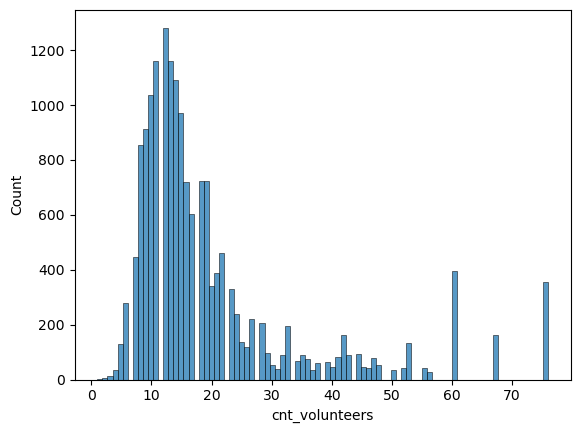

In [90]:
sns.histplot(num_col_starts.cnt_volunteers)

Семен делает статтесты для проверки значимости разницы средних выборок С опред. волонтерами и БЕЗ них

In [91]:
cnt_ludei = starts.groupby(['event_name', 'event_date']).agg(
    cnt_runners = ('athlete_id', 'count'),
    region = ('region', 'last'),
    discomfort_index = ('discomfort_index','last')
)

info_about_jogging = first_runs.groupby(['event_name', 'event_date', 'region']).agg(
    pridut = ('athlete_id', lambda x: len(x[first_runs['is_repeated'] == 1])),
    ne_pridut = ('athlete_id', lambda x: len(x[first_runs['is_repeated'] == 0])),
    vsego_newbie = ('athlete_id', 'count'), 
    mean_age = ('athlete_age', 'mean'),
    mean_finish_time = ('finish_time', 'mean'),
    mean_gender =('is_male', lambda x: x.sum() / len(x))        #чем ближе к 1 - тем больше мужчин на пробежке было

).reset_index()
info_about_jogging = info_about_jogging.merge(cnt_ludei, on=['event_date', 'event_name', 'region'], how='left')
info_about_jogging = info_about_jogging.merge(volunteer_counts, on=['event_date','event_name'], how='left')  

info_about_jogging = info_about_jogging.fillna(0)
info_about_jogging['otnos_ne_pridut'] = info_about_jogging['ne_pridut'] / info_about_jogging['vsego_newbie']

print(len(info_about_jogging))
info_about_jogging['cnt_volunteers'] = info_about_jogging.iloc[:, 10:37].sum(axis=1)

display(info_about_jogging.head(5))


3546


,event_name,event_date,region,pridut,ne_pridut,vsego_newbie,mean_age,mean_finish_time,mean_gender,cnt_runners,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,otnos_ne_pridut,cnt_volunteers
0,Александрино,2023-04-08,Санкт-Петербург,9,7,16,40.500000,2180.625000,0.500000,81,6.28660,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,2,1,0,0,0,2,0,0.437500,17.28660
1,Александрино,2023-04-15,Санкт-Петербург,5,4,9,41.555556,1826.222222,0.444444,20,6.67771,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.444444,16.67771
2,Александрино,2023-04-22,Санкт-Петербург,4,2,6,34.666667,1670.166667,0.500000,15,11.58912,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0.333333,19.58912
3,Александрино,2023-04-29,Санкт-Петербург,6,1,7,43.571429,2029.142857,0.428571,22,6.01066,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.142857,14.01066
4,Александрино,2023-05-06,Санкт-Петербург,4,2,6,39.500000,2014.333333,0.500000,26,7.70362,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0.333333,15.70362


In [92]:
come_with_didnt_come = come_with_didnt_come.merge(info_about_jogging, on=['event_name', 'event_date'], how='left')

In [102]:
come_with_didnt_come.cnt_runners.describe()

count    17333.000000
mean        87.232158
std        120.973628
min          2.000000
25%         28.000000
50%         45.000000
75%         76.000000
max        576.000000
Name: cnt_runners, dtype: float64

In [103]:
def assign_cluster(x):
    if x >= 76:
        return 4
    elif (x >= 45) & (x <= 76):
        return 3
    elif (x >= 28) & (x <= 45):
        return 2
    else:
        return 1

come_with_didnt_come['cluster_cnt_runners'] = come_with_didnt_come['cnt_runners'].apply(assign_cluster)

In [104]:
come_with_didnt_come.cluster_cnt_runners.value_counts()


cluster_cnt_runners
4    4484
2    4348
1    4268
3    4233
Name: count, dtype: int64

In [ ]:
come_with_didnt_come.Маршал.value_counts()

Маршал
0.0     5450
1.0     3976
2.0     2330
3.0     1599
5.0      770
4.0      746
11.0     490
6.0      478
27.0     355
13.0     235
7.0      175
9.0      144
8.0      106
12.0      75
10.0      44
15.0      26
Name: count, dtype: int64

In [ ]:
come_with_didnt_come.merge(info_about_jogging)

In [ ]:
come_with_didnt_come['Инструктаж новых участников'].value_counts()

Инструктаж новых участников
0.0    10399
1.0     6382
2.0      145
3.0       73
Name: count, dtype: int64

In [ ]:
with_marshal_and_instr = come_with_didnt_come[['Маршал', 'Инструктаж новых участников', 'is_repeated']]

In [ ]:
marshal_0 = with_marshal_and_instr[with_marshal_and_instr.Маршал == 0].is_repeated
marshal_1 = with_marshal_and_instr[with_marshal_and_instr.Маршал >= 1].is_repeated
print(marshal_0.value_counts())
print(marshal_0.shape[0], marshal_1.shape[0], marshal_1.value_counts()[1]/marshal_1.shape[0], marshal_0.value_counts()[0]/marshal_0.shape[0])

is_repeated
1    3085
0    2365
Name: count, dtype: int64
5450 11549 0.49891765520824316 0.43394495412844036


In [ ]:
marshal_0.value_counts()

is_repeated
1    3085
0    2365
Name: count, dtype: int64

In [ ]:
marshal_1.value_counts()

is_repeated
0    5787
1    5762
Name: count, dtype: int64

Доля успехов не экстремальна, выборка достаточно большая ==> для сравнения выборок будем делать двухпропорциональный Z-тест на долях 

In [ ]:
x1 = marshal_0.value_counts()[0]
n1 = marshal_0.shape[0]
x2 = marshal_1.value_counts()[1]
n2 = marshal_1.shape[0]
count = [x1, x2]
nobs = [n1, n2]
stats, pval = statsmodels.stats.proportion.proportions_ztest(count, nobs, value=0)
print('Z-value:', stats)
print('p value:', pval)

Z-value: -7.914749136934743
p value: 2.4775213345210145e-15


In [135]:
volunteers_cols = come_with_didnt_come.columns[25:52]  

In [141]:
come_with_didnt_come = come_with_didnt_come.drop(columns=['Координатор парковки_x', 'Лидер для слабовидящих_x', 'Организация финиша_x', 'Пейсер_x', 'Раздача карточек позиций_x', 'Составление отчёта_x', 'Сурдопереводчик_x'])

In [142]:
len(['Координатор парковки_x', 'Лидер для слабовидящих_x', 'Организация финиша_x', 'Пейсер_x', 'Раздача карточек позиций_x', 'Составление отчёта_x', 'Сурдопереводчик_x'])

7

In [146]:
volunteers_cols = come_with_didnt_come.columns[25:45]  

results = []
for cluster_val in [1, 2, 3, 4]:
    df_cluster = come_with_didnt_come[come_with_didnt_come['cluster_cnt_runners'] == cluster_val]
    for vol in volunteers_cols:
        group_vol = df_cluster[df_cluster[vol] > 0]
        group_no_vol = df_cluster[df_cluster[vol] == 0]
        
        x1 = group_vol['is_repeated'].sum()
        n1 = group_vol.shape[0]
        x2 = group_no_vol['is_repeated'].sum()
        n2 = group_no_vol.shape[0]


        if min(x1, n1 - x1, x2, n2 - x2) < 5:
            table = np.array([[x1, n1 - x1],
                            [x2, n2 - x2]])
            oddsratio, p_value = fisher_exact(table)
            test_type = 'Fisher'
        else:
            count = [x1, x2]
            nobs = [n1, n2]
            stat, p_value = proportions_ztest(count, nobs, value=0)
            test_type = 'Z-test'
        
        results.append({
            'cluster' : cluster_val,
            'volunteer': vol,
            'test_type': test_type,
            'p_value': p_value,
            'n1': n1,
            'n2': n2,
            'p1': x1/n1 if n1>0 else np.nan,
            'p2': x2/n2 if n2>0 else np.nan,
            'significant': 1 if p_value<0.05 else 0
        })
        z_results = pd.DataFrame(results)

In [150]:
z_results.groupby(['cluster', 'volunteer']).significant.sum()

cluster  volunteer                          
1        Ведущий велосипед_x                    0
         Завершение мероприятия_x               0
         Замыкающий_x                           1
         Инструктаж новых участников_x          0
         Координация волонтёров_x               0
         Маршал_x                               0
         Обработка результатов_x                0
         Организатор_x                          0
         Подготовка мероприятия_x               0
         Помощь в раздаче карточек позиций_x    0
         Проведение разминки_x                  0
         Проверка карточек позиций_x            0
         Проверка трассы_x                      0
         Разное_x                               0
         Связи с общественностью_x              0
         Секундомер_x                           1
         Сканирование штрих-кодов_x             0
         Сортировка карточек_x                  0
         Фотограф_x                             1
     

In [148]:
significant_df = z_results[z_results['p_value'] < 0.05]
cluster_volunteers_dict = (significant_df
                           .groupby('cluster')['volunteer']
                           .unique()
                           .to_dict())
print(cluster_volunteers_dict.items())

dict_items([(1, array(['Замыкающий_x', 'Секундомер_x', 'Фотограф_x'], dtype=object)), (2, array(['Проведение разминки_x', 'Сортировка карточек_x',
       'Хранение и доставка оборудования_x'], dtype=object)), (3, array(['Координация волонтёров_x', 'Проверка карточек позиций_x',
       'Проверка трассы_x', 'Хранение и доставка оборудования_x'],
      dtype=object)), (4, array(['Ведущий велосипед_x', 'Завершение мероприятия_x',
       'Координация волонтёров_x', 'Маршал_x', 'Подготовка мероприятия_x',
       'Помощь в раздаче карточек позиций_x', 'Проведение разминки_x',
       'Проверка карточек позиций_x', 'Проверка трассы_x', 'Разное_x',
       'Связи с общественностью_x', 'Сортировка карточек_x',
       'Хранение и доставка оборудования_x'], dtype=object))])


0.05

1: Замыкающий, Секундомер, Фотограф 



 2: Проведение разминки, Сортировка карточек, Хранение и доставка оборудования


3: Координация волонтёров, Проверка карточек позиций,
       Проверка трассы, Хранение и доставка оборудования   


       
4: Ведущий велосипед, Завершение мероприятия,
       Координация волонтёров, Маршал, Подготовка мероприятия,
       Помощь в раздаче карточек позиций, Проведение разминки,
       Проверка карточек позиций, Проверка трассы, Разное,
       Связи с общественностью, Сортировка карточек,
       Хранение и доставка оборудования


0.1


 
1: Замыкающий, Маршал, Секундомер,
Сканирование штрих-кодов, Фотограф 



 2: Координация волонтёров, Проведение разминки,
       Сортировка карточек, Хранение и доставка оборудования


       
3: Координация волонтёров, Проверка карточек позиций,
       Проверка трассы, Хранение и доставка оборудования   


       
4: Ведущий велосипед, Завершение мероприятия,
       Координация волонтёров, Маршал, Подготовка мероприятия,
       Помощь в раздаче карточек позиций, Проведение разминки,
       Проверка карточек позиций, Проверка трассы, Разное,
       Связи с общественностью, Сортировка карточек,
       Хранение и доставка оборудования